## Feature extractor selection

### Settings

Import the libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

c:\Users\markz\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.10.0


## Data augmentation and loading

In [2]:
# Random seed for reproducibility
seed = 45

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
# Labels
LABELS = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8']

In [4]:
# Model hyperparameters
INPUT_SHAPE = (96, 96, 3)
IMAGE_SIZE = (INPUT_SHAPE[0], INPUT_SHAPE[1])

LAYERS_TO_FREEZE = 100

EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

NUM_CLASSES = len(LABELS)
MODEL_NAME = "cnn"

In [5]:
# Paths
DATA_DIR = 'C:\\Users\\markz\\Desktop\\ANN_chall_1\\training_data_final'

PATH = {}
PATH['training'] = os.path.join(DATA_DIR, 'training')
PATH['validation'] = os.path.join(DATA_DIR, 'validation')
PATH['testing'] = os.path.join(DATA_DIR, 'testing')

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Constructor
train_data_gen = ImageDataGenerator(
    rotation_range=30,
    height_shift_range=40,
    width_shift_range=40,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7,1.3],
    fill_mode='reflect'
) 

# Generator
train_gen = train_data_gen.flow_from_directory(
    directory=PATH['training'],
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=seed
)

Found 2122 images belonging to 8 classes.


In [7]:
# Constructor
valid_data_gen = ImageDataGenerator()

# Generator
valid_gen = valid_data_gen.flow_from_directory(
    directory=PATH['validation'],
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=seed
)

Found 707 images belonging to 8 classes.


In [8]:
# Constructor
test_data_gen = ImageDataGenerator()

# Generator
test_gen = test_data_gen.flow_from_directory(
    directory=PATH['testing'],
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=seed
)

Found 713 images belonging to 8 classes.


## Model training

In [9]:
unique, counts = np.unique(train_gen.classes, return_counts=True)
rec = dict(zip(unique, counts))

max_value = rec[max(rec, key=rec.get)]

cw = {}

for k in rec.keys():
    cw[k] = max_value/rec[k]

#print(cw)

cw[0] = 5.0
for i in range(1,8):
    cw[i] = 1.0
cw[5] = 3.0
cw[7] = 1.3

print(cw)

{0: 5.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 3.0, 6: 1.0, 7: 1.3}


In [10]:
models = ['vgg16','resnet50','efficientnetb0','efficientnetv2-s','convnext_tiny','convnext_base']

In [11]:

# Create the model using the downloaded pretrained model bottom and adding the classifier

def getModel(name):
    if name == 'vgg16': return tf.keras.applications.VGG16(include_top=False,input_shape=INPUT_SHAPE,weights='imagenet')
    elif name == 'resnet50': return tf.keras.applications.ResNet50(include_top=False,input_shape=INPUT_SHAPE,weights='imagenet')
    elif name == 'efficientnetb0': return tf.keras.applications.EfficientNetB0(include_top=False,input_shape=INPUT_SHAPE,weights='imagenet')
    elif name == 'efficientnetv2-s': return tf.keras.applications.EfficientNetV2S(include_top=False,input_shape=INPUT_SHAPE,weights='imagenet')
    elif name == 'convnext_tiny': return tf.keras.applications.ConvNeXtTiny(include_top=False,input_shape=INPUT_SHAPE,weights='imagenet')
    elif name == 'convnext_base': return tf.keras.applications.ConvNeXtBase(include_top=False,input_shape=INPUT_SHAPE,weights='imagenet')

# kernel_regularizer=tf.keras.regularizers.L1(reg)
def createModel(bottom, id='model', lr=1e-3, neurons=256):
    
    bottom.trainable = False

    inputs = tfk.Input(shape=INPUT_SHAPE)
    x = bottom(inputs)
    x = tfkl.GlobalAveragePooling2D()(x)
    x = tfkl.Dense(neurons, kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
    x = tfkl.ReLU()(x)
    outputs = tfkl.Dense(
        NUM_CLASSES, 
        activation='softmax',
        kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

    m = tfk.Model(inputs=inputs, outputs=outputs, name=id)
    m.get_layer(id).trainable = True
    m.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])

    return m

def trainModel(m, model_name, layers_to_freeze, weights, batch_s=64, ep=100):

    with tf.device("/GPU:0"):
        m.get_layer(model_name).trainable = True
        freeze = round(layers_to_freeze * len(m.get_layer(model_name).layers))

        print('Freezing '+str(freeze)+' layers')

        for layer in m.get_layer(model_name).layers[:freeze]:
            layer.trainable=False
        h = m.fit(
            x = train_gen,
            batch_size = batch_s,
            epochs = ep,
            validation_data = valid_gen,
            class_weight=weights,
            verbose=0,
            callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.7, patience=5, min_lr=0.0, min_delta=0.00001)]
        ).history
    
    return h

In [ ]:
results = {}

# Finds the best model for each feature extractor
for k in models:
    print('Training ' + k)
    # Trains 4 variants of the model
    best_acc = 0.0
    for freeze in [0,0.3,0.6,0.9]:
        print('Fitting variant with ' + str(freeze) + ' bottom layers frozen')
        model_p = createModel(getModel(k), id=k, lr=LEARNING_RATE, neurons=256)
        history_p = trainModel(model_p, k, freeze, cw, batch_s=BATCH_SIZE, ep=EPOCHS)
        m_acc = max(history_p['val_accuracy'])
        print('Accuracy: ' + str(m_acc))

        # Updates the best variant
        if m_acc > best_acc:
            best_acc = m_acc
            results[k] = (model_p, history_p, freeze)


In [18]:
v = []
for k in results.keys():
    v.append((k,results[k][2],max(results[k][1]['val_accuracy'])))

In [19]:
for k in v: print(k)

('vgg16', 0.6, 0.6605374813079834)
('resnet50', 0.9, 0.8486562967300415)
('efficientnetb0', 0, 0.909476637840271)
('efficientnetv2-s', 0.9, 0.9024045467376709)
('convnext_tiny', 0.9, 0.892503559589386)
('convnext_base', 0.6, 0.8868458271026611)


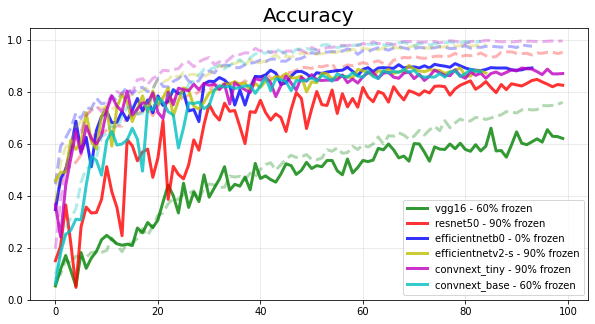

In [42]:
plt.figure(figsize=(10,5))

plt.plot(results['vgg16'][1]['accuracy'], alpha=.3, color='g', linestyle='--', linewidth=3)
plt.plot(results['vgg16'][1]['val_accuracy'], label='vgg16 - '+str(int(results['vgg16'][2]*100))+'% frozen', alpha=.8, color='g', linewidth=3)

plt.plot(results['resnet50'][1]['accuracy'], alpha=.3, color='r', linestyle='--', linewidth=3)
plt.plot(results['resnet50'][1]['val_accuracy'], label='resnet50 - '+str(int(results['resnet50'][2]*100))+'% frozen', alpha=.8, color='r', linewidth=3)

plt.plot(results['efficientnetb0'][1]['accuracy'], alpha=.3, color='b', linestyle='--', linewidth=3)
plt.plot(results['efficientnetb0'][1]['val_accuracy'], label='efficientnetb0 - '+str(int(results['efficientnetb0'][2]*100))+'% frozen', alpha=.8, color='b', linewidth=3)

plt.plot(results['efficientnetv2-s'][1]['accuracy'], alpha=.3, color='y', linestyle='--', linewidth=3)
plt.plot(results['efficientnetv2-s'][1]['val_accuracy'], label='efficientnetv2-s - '+str(int(results['efficientnetv2-s'][2]*100))+'% frozen', alpha=.8, color='y', linewidth=3)

plt.plot(results['convnext_tiny'][1]['accuracy'], alpha=.3, color='m', linestyle='--', linewidth=3)
plt.plot(results['convnext_tiny'][1]['val_accuracy'], label='convnext_tiny - '+str(int(results['convnext_tiny'][2]*100))+'% frozen', alpha=.8, color='m', linewidth=3)

plt.plot(results['convnext_base'][1]['accuracy'], alpha=.3, color='c', linestyle='--', linewidth=3)
plt.plot(results['convnext_base'][1]['val_accuracy'], label='convnext_base - '+str(int(results['convnext_base'][2]*100))+'% frozen', alpha=.8, color='c', linewidth=3)

plt.legend(bbox_to_anchor=(0.66, 0), loc="lower left")

plt.title('Accuracy', fontsize=20)
plt.grid(alpha=.3)
plt.show()